In [1]:
import matplotlib.pyplot as plt
import torch

from fitting import create_ensemble, load_data, create_datasets
import torch
labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)","z (mm)",r"$p_z$ (mrad)"]

tkwargs = {"dtype": torch.float}
base_dir = "/global/cfs/cdirs/m669/rroussel/phase_space_reconstruction/"
save_dir = base_dir + "mse_scale_1_l_1e12"
quad_strengths, image_data, bins, xx = load_data(base_dir, tkwargs)
xx = xx.cpu()

quad_strengths = quad_strengths[:,[0,4,3],:][:20]
image_data = image_data[:,[0,4,3],:][:20]

train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

n_particles = 1000000
for ele in ensemble:
    ele.beam.set_base_beam(
        ele.beam.base_dist,
        n_particles,
        p0c=torch.tensor(63.0e6)
    )

ensemble = ensemble.cuda();


/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
quad_strengths.shape

torch.Size([20, 3, 1])

In [3]:
from phase_space_reconstruction.utils import calculate_ellipse
offset = 0
# calculate rms stats from each image
covs = []
centroids = []
image_data = torch.clip(image_data, offset) - offset
for ele in image_data.transpose(-1,-2):
    centroid, cov = calculate_ellipse(ele, bins, bins)
    covs += [cov]
    centroids += [centroid]

covs = torch.stack(covs).detach().cpu()
centroids = torch.stack(centroids)

# plot reconstruction covs
rcovs = []
rcentroids = []
predictions = []
with torch.no_grad():
    for i in range(len(ensemble)):
        print(i)
        en_covs = []
        en_centroids = []
        en_pred = []
        for j in range(quad_strengths.shape[0]):
            k_covs = []
            k_centroids = []
            k_pred = []
            for k in range(quad_strengths.shape[1]):
                p, _, _ = ensemble[i](quad_strengths[j,k,:].unsqueeze(1).cuda())
                p = torch.clip(p.cpu(), offset) - offset
                centroid, cov = calculate_ellipse(p.transpose(-2,-1), bins, bins)
                k_covs += [cov]
                k_centroids += [centroid]

                k_pred += [p.detach().cpu()]
            
                torch.cuda.empty_cache()
                
            en_covs += [torch.stack(k_covs).squeeze()]
            en_centroids += [torch.stack(k_centroids).squeeze()]
            en_pred += [torch.stack(k_pred).squeeze()]
            
        rcovs += [torch.stack(en_covs).squeeze()]
        rcentroids += [torch.stack(en_centroids).squeeze()]
        predictions += [torch.stack(en_pred).squeeze()]
        
rcovs = torch.stack(rcovs).transpose(0,1)
rcovs_mean = rcovs.mean(dim=[1,2])
rcovs_std = rcovs.std(dim=[1,2])
rcentroids = torch.stack(rcentroids).transpose(0,1)
predictions = torch.stack(predictions).transpose(0,1)
mean_predictions = predictions.mean(dim=(1,2))

0
1
2
3


In [4]:
print(covs.shape)
print(rcovs.shape)
print(rcovs_mean.shape)
print(rcentroids.shape)
print(predictions.shape)
print(mean_predictions.shape)
print(bin_width)

torch.Size([20, 3, 2, 2])
torch.Size([20, 4, 3, 2, 2])
torch.Size([20, 2, 2])
torch.Size([20, 4, 3, 2])
torch.Size([20, 4, 3, 500, 500])
torch.Size([20, 500, 500])
tensor(4.1620e-05)


In [5]:
print([ele[0] for ele in train_dset])

[tensor([[4.2382],
        [4.2382],
        [4.2382]]), tensor([[3.3906],
        [3.3906],
        [3.3906]]), tensor([[2.5429],
        [2.5429],
        [2.5429]]), tensor([[1.6953],
        [1.6953],
        [1.6953]]), tensor([[0.8476],
        [0.8476],
        [0.8476]]), tensor([[-0.],
        [-0.],
        [-0.]]), tensor([[-0.8476],
        [-0.8476],
        [-0.8476]]), tensor([[-1.6953],
        [-1.6953],
        [-1.6953]]), tensor([[-2.9244],
        [-2.9244],
        [-2.9244]]), tensor([[-4.6620],
        [-4.6620],
        [-4.6620]])]


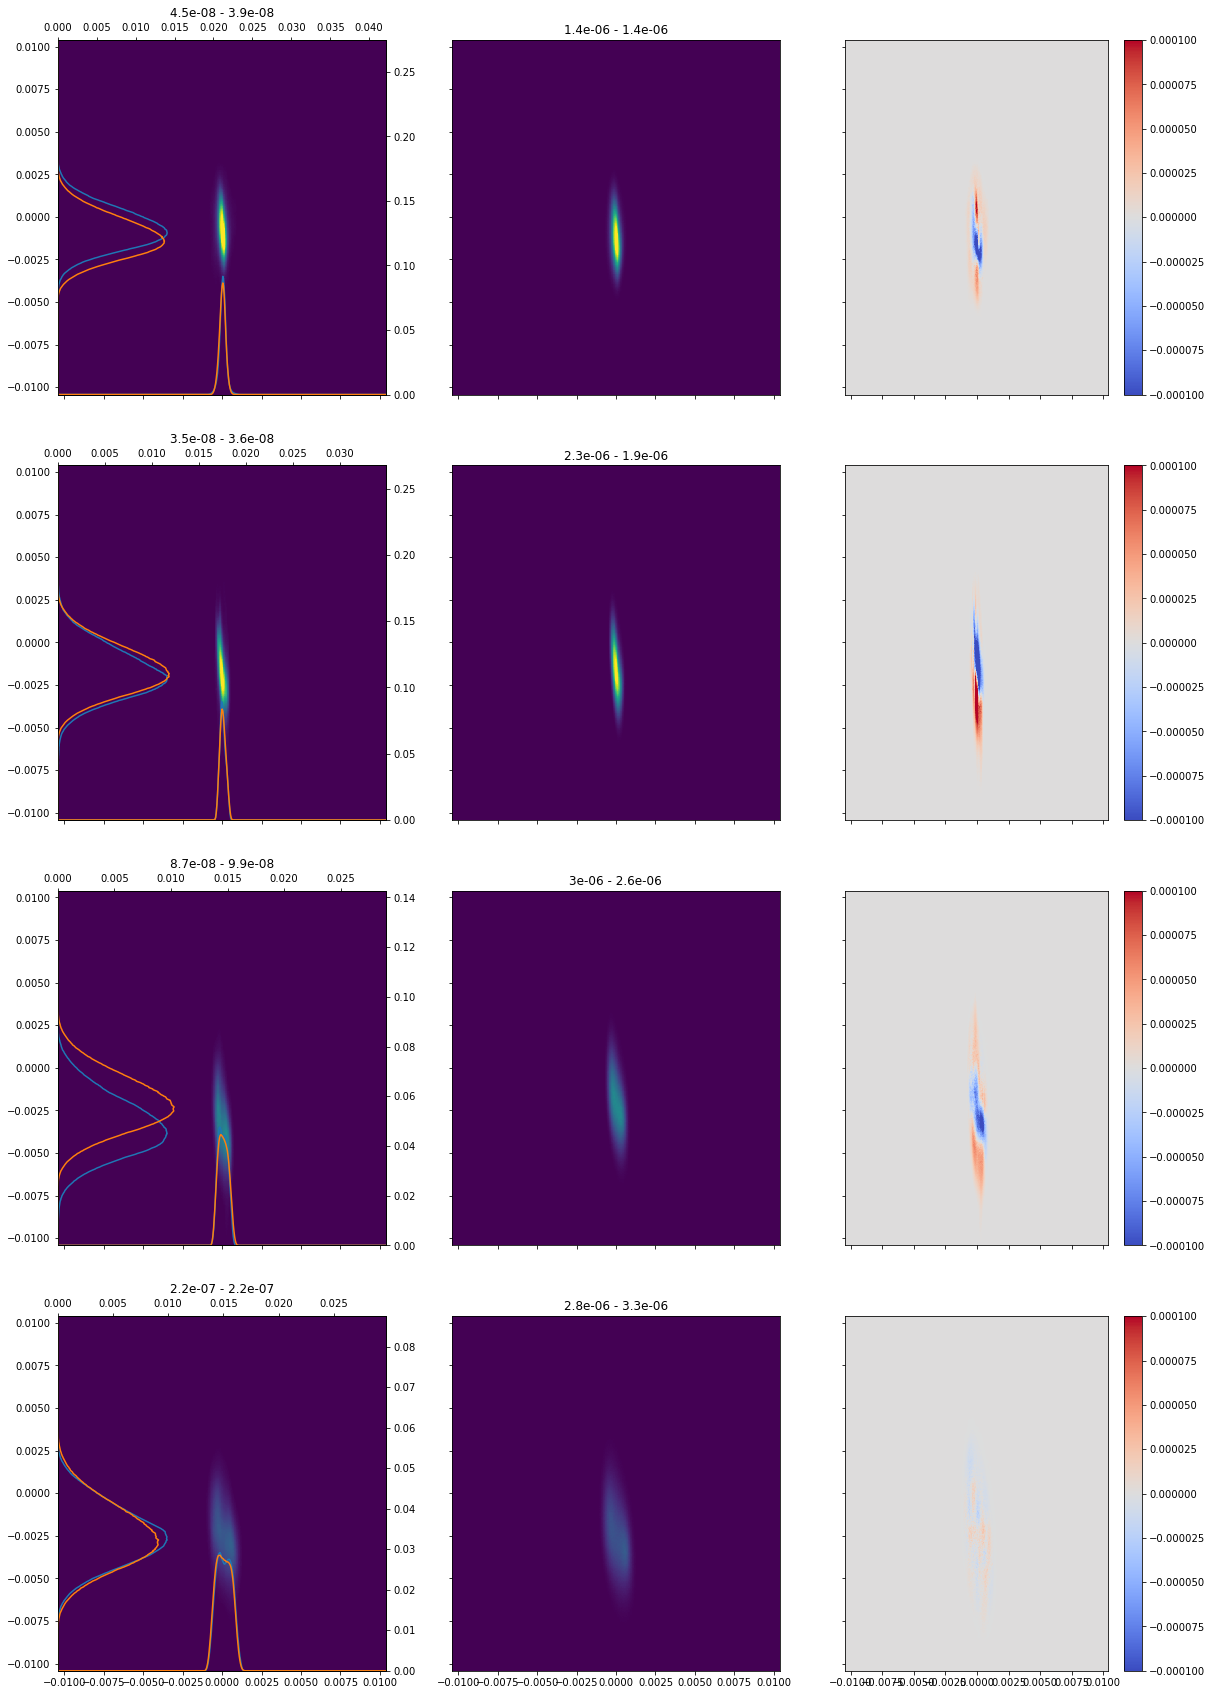

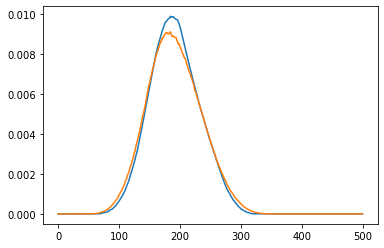

In [6]:
import numpy as np
indicies = np.arange(-5,-1)

fig,ax = plt.subplots(len(indicies),3,sharex="all", sharey="all")
fig.set_size_inches(20,30)
shot_index = 0

vmax = 0.001
for i, index in enumerate(indicies):
    ax[i][0].pcolor(*xx, 
                    image_data[index][shot_index].cpu().detach(),
                    vmin=0,vmax=vmax
                    )
    ax[i][1].pcolor(*xx, 
                    mean_predictions[index].cpu().detach(), 
                    vmin=0,vmax=vmax)

    c = ax[i][2].pcolor(*xx,image_data[index].mean(dim=0).cpu().detach() - mean_predictions[index].cpu()
                    .detach(),cmap="coolwarm",vmin=-vmax*0.1, vmax=vmax*0.1)
    fig.colorbar(c, ax=ax[i][2])
    axb = ax[i][0].twinx()
    axb.plot(bins, image_data[index][shot_index].sum(dim=-2))
    axb.plot(bins, mean_predictions[index].sum(dim=-2))
    axb.set_ylim(0.0, image_data[index][shot_index].sum(dim=-2).max()*3)
    
    axc = ax[i][0].twiny()
    axc.plot(image_data[index][shot_index].sum(dim=-1),bins)
    axc.plot(mean_predictions[index].sum(dim=-1),bins)
    axc.set_xlim(0.0, image_data[index][shot_index].sum(dim=-1).max()*3)
    
    axb.set_title(f"{covs[index,shot_index,1,1]:.2} - {rcovs[index,shot_index,0,1,1]:.2}")
    ax[i][1].set_title(f"{covs[index,shot_index,0,0]:.2} - {rcovs[index,shot_index,0,0,0]:.2}")

plt.figure()
plt.plot(image_data[index][shot_index].sum(dim=-1))
plt.plot(mean_predictions[index].sum(dim=-1))



In [7]:
# traing scalar model
from phase_space_reconstruction.modeling import NormalizedQuadScan

# fit phase spaces
train_s11 = covs[::2][...,0,0].detach().cpu().flatten()
train_s22 = covs[::2][...,1,1].detach().cpu().flatten()
train_k = quad_strengths[::2].flatten().cpu()

rms_data = torch.stack((train_k, train_s11, train_s22))
torch.save(rms_data, "rms_data.pt")

models = []

for ele in [train_s11, train_s22]:
    quad_length = torch.tensor(0.12)
    drift = torch.tensor(3.38 - 0.12/2)
    A = train_s11.max().sqrt()

    model = NormalizedQuadScan(A, drift, quad_length)

    optimizer = torch.optim.Adam(
            model.parameters(), lr=0.01
    )

    for i in range(25000):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_k)
        # Calc loss and backprop gradients
        loss = torch.abs(output*1e6 - ele*1e6).mean()
        loss.backward()
        if not i % 2000:
            print(loss)
        optimizer.step()

    models += [model]

    print(model.emittance() * 63.0 / 0.511)

tensor(42.3547, grad_fn=<MeanBackward0>)
tensor(0.0938, grad_fn=<MeanBackward0>)
tensor(0.0792, grad_fn=<MeanBackward0>)
tensor(0.0796, grad_fn=<MeanBackward0>)
tensor(0.0800, grad_fn=<MeanBackward0>)
tensor(0.0792, grad_fn=<MeanBackward0>)
tensor(0.0793, grad_fn=<MeanBackward0>)
tensor(0.0794, grad_fn=<MeanBackward0>)
tensor(0.0793, grad_fn=<MeanBackward0>)
tensor(0.0794, grad_fn=<MeanBackward0>)
tensor(0.0798, grad_fn=<MeanBackward0>)
tensor(0.0807, grad_fn=<MeanBackward0>)
tensor(0.0794, grad_fn=<MeanBackward0>)
tensor(4.2395e-06, grad_fn=<DivBackward0>)
tensor(42.4189, grad_fn=<MeanBackward0>)
tensor(0.0607, grad_fn=<MeanBackward0>)
tensor(0.0530, grad_fn=<MeanBackward0>)
tensor(0.0530, grad_fn=<MeanBackward0>)
tensor(0.0537, grad_fn=<MeanBackward0>)
tensor(0.0530, grad_fn=<MeanBackward0>)
tensor(0.0531, grad_fn=<MeanBackward0>)
tensor(0.0533, grad_fn=<MeanBackward0>)
tensor(0.0530, grad_fn=<MeanBackward0>)
tensor(0.0531, grad_fn=<MeanBackward0>)
tensor(0.0531, grad_fn=<MeanBackwar

In [8]:
import numpy as np
from scipy.ndimage import median_filter, gaussian_filter

def get_contour_levels(image, quantiles):
    # smooth image
    
    # get cdf of densities
    vmax = image.max()
    test_levels = np.linspace(0, vmax, 1000)
    
    # for each level calculate the fractional sum
    total = image.sum()
    sums = []
    for ele in test_levels:
        sums += [np.where(image >= ele, image, 0.0).sum() / total]
    sums = np.array(sums)

    # calculate levels
    levels = []
    for ele in quantiles[::-1]:
        diff = sums - ele
        levels += [test_levels[np.where(np.diff(np.sign(diff)))]]
        
    return np.array(levels).flatten()

-4.662016882171631
-2.119093193283081
-0.8476312892341614
0.4238306446170807
1.6952925784683228
2.9243724210357667
(2, 3)


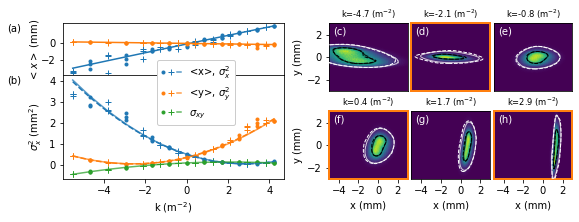

In [17]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple


fig = plt.figure(figsize=np.array((8,3))*1)
subfigs = fig.subfigures(1,2, wspace=0.0)

ax = subfigs[0].subplots(2,1,gridspec_kw={"left":0.2,"right":0.97, "top":0.92,"bottom":0.2,"hspace":0.0, "height_ratios":[0.5,1.0]})

image_ax = subfigs[1].subplots(2,3,sharex="all",sharey="all",
                               gridspec_kw={"hspace":0.3,"wspace":0.05,"right":0.97,"top":0.92,"bottom":0.2})
#fig,ax = plt.subplots(2,4,sharex="col",gridspec_kw={"width_ratios":[1.0,0.5,0.5,0.5],"hspace":0.05})

test_quad_strength = torch.linspace(quad_strengths.min(), quad_strengths.max(),100)

# plot centroids
#######################################################################
centroid_axis = ax[0]
cov_axis = ax[1]
colors = ["C0","C1"]
if 1:
    for i in range(2):
        centroid_axis.plot(
            quad_strengths[::2].detach().cpu().flatten(), 
            centroids[...,i][::2].detach().cpu().flatten()*1e3,
            f".{colors[i]}"
        )
        
        centroid_axis.plot(
            quad_strengths[1::2].detach().cpu().flatten(), 
            centroids[...,i][1::2].detach().cpu().flatten()*1e3,
            f"+{colors[i]}"
        )

        centroid_axis.plot(
            quad_strengths[:,0,:].detach().cpu().flatten(), 
            rcentroids[:,0,0,i].detach().cpu().flatten()*1e3,
            f"{colors[i]}"
        )
centroid_axis.set_ylabel("$<x>$ (mm)",labelpad=0)
centroid_axis.set_yticks([0,-2])
        
# plot covs
#######################################################################
slices = [[0,0],[1,1],[0,1]]

var_labels = ["<x>, $\sigma_x^2$","<y>, $\sigma_y^2$","$\sigma_{xy}$"]
base_labels = ["$\sigma_{x}^2$","$\sigma_{y}^2$","$\sigma_{xy}$"]
train_labels = ["$\sigma_{x,train}^2$","$\sigma_{y,train}^2$","$\sigma_{xy,train}$"]
test_labels = ["$\sigma_{x,test}^2$","$\sigma_{y,test}^2$","$\sigma_{xy,test}$"]
reconstruction_labels = ["$\sigma_{x,recon}^2$","$\sigma_{y,recon}^2$","$\sigma_{xy,recon}$"]
rms_fit_labels = ["$\sigma_{x,fit}^2$","$\sigma_{y,fit}^2$","$\sigma_{xy,fit}$"]
lines = []
for i in range(3):
    train, = cov_axis.plot(
        quad_strengths[::2].detach().cpu().flatten(),
        covs[::2][...,slices[i][0],slices[i][1]].flatten()*1e6,
        f".C{i}",
        label=train_labels[i]
    )
    
    test, = cov_axis.plot(
        quad_strengths[1::2].detach().cpu().flatten(),
        covs[1::2][...,slices[i][0],slices[i][1]].flatten()*1e6,
        f"+C{i}",
        label=test_labels[i]
    )
    
    recon, = cov_axis.plot(
        quad_strengths[:,0,:].detach().cpu().flatten(),
        rcovs_mean[...,slices[i][0],slices[i][1]].flatten()*1e6,
        f"C{i}",
        alpha=0.75,
        zorder=10
        #rcovs_std[...,slices[i][0],slices[i][1]].flatten()*1e6,
        #capsize=5
    )
    lines += [[train, test,recon]]
    
for ele,a in zip(["a","b"],ax):
    a.text(-0.25, 1.0, f"({ele})", ha='left',
                           va='top', transform=a.transAxes)
    
for i in range(2):
    with torch.no_grad():
        pred = models[i](test_quad_strength)
        
    fit, = cov_axis.plot(test_quad_strength, pred*1e6,f"--C{i}")

# annotate
#reconstruction_pt = np.array((quad_strengths[18,0,:].detach().cpu(), rcovs_mean[18,0,0]*1e6))
#cov_axis.annotate("Reconstruction", 
#            xy = reconstruction_pt + np.array((0.3,-0.3)),
#            xytext = reconstruction_pt + np.array((1.5,0.2)),
#            arrowprops=dict(arrowstyle="->")
#           )

#pred = models[0](test_quad_strength)
#fit_pt = np.array((test_quad_strength[5], pred[5].detach()*1e6))
#cov_axis.annotate("RMS Fit", 
#            xy = fit_pt,
#            xytext = fit_pt + np.array((1.0,0.6)),
#            arrowprops=dict(arrowstyle="->")
#           )



cov_axis.legend([tuple(ele) for ele in lines], var_labels, handler_map={tuple: HandlerTuple(ndivide=None)},ncol=1,bbox_to_anchor=(0.8,1.2),framealpha=1.0)
cov_axis.set_xlabel("k (m$^{-2}$)")
cov_axis.set_ylabel("$\sigma_{x}^2$ (mm$^{2}$)",labelpad=5)

# plot images
########################################################################################
indicies = torch.arange(18,0,-3)
q_strengths = quad_strengths[indicies,0,0]
shot_index = 0

ylims = [-3,3]
xlims = [-5,3]
axes = image_ax.flatten()

q = [0.5,0.95]
colors = ["white","black"]

for i, index in enumerate(indicies):
    image = image_data[index].mean(dim=0).cpu().detach().T
    pred = mean_predictions[index].cpu().detach().T
             
    vmax = torch.stack((image, pred)).max()*1.1
    
    image_contours = get_contour_levels(image, q)
    pred_contours = get_contour_levels(pred, q)
    
    #image_ax[0][i].pcolor(*xx*1e3, 
    #                image_data[index].mean(dim=0).cpu().detach().T,
    #                vmax=vmax
    #                )
    axes[i].set_xlim(*xlims)
    axes[i].set_ylim(*ylims)

    axes[i].pcolor(*xx*1e3, pred, vmax=vmax)
    
    c2 = axes[i].contour(*xx*1e3, image, levels=image_contours,
                        colors=colors,linestyles="dashed",
                        zorder=3,linewidths=1)
    c3 = axes[i].contour(*xx*1e3, pred, levels=pred_contours,
                        colors=colors,#linestyles="dashed",
                        zorder=4,linewidths=1,alpha=0.75)
    
    
    print(q_strengths[i].numpy() + 1e-5)
    # add tiny amount to correct -0.0 issue when displaying number
    axes[i].set_title(f"k={q_strengths[i].numpy() + 1e-5:.1f} (m$^{{-2}}$)", fontsize="small")
    
    if index % 2:
        # shade test images
        for spine in axes[i].spines.values():
                spine.set_edgecolor('C1')
                spine.set_linewidth(2)
    
print(image_ax.shape)
# remove excess ticks
for ele in image_ax[0]:
    ele.tick_params(axis='x', which='both', bottom=False)
for ele in image_ax[:,1:].flatten():
    ele.tick_params(axis='y', which='both', left=False)

for ele in image_ax[:,0]:
    ele.set_ylabel("y (mm)")
    ele.set_yticks([-2,0,2])
for ele in image_ax[-1,:]:
    ele.set_xlabel("x (mm)")
    ele.set_xticks([-4,-2,0,2])
    


    
# add labels
letters = "cdefghijk"
for a, l in zip(image_ax.flatten(),letters):
    a.text(0.05, 0.95, f"({l})", ha='left', color = "white", va='top', transform=a.transAxes)
    
fig.savefig("rms_analysis.png",dpi=300)

In [10]:
# do bayesian linear regression using pyro
import pyro
from pyro import poutine

from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist

from pyro.infer import Predictive
from pyro.infer.autoguide import AutoNormal

class PyroNormalizedQuadScan(NormalizedQuadScan, PyroModule):
    def __init__(self, A, drift, quad_length):
        super().__init__(A, drift, quad_length)
        #self.sigma = PyroSample(dist.Uniform(0., 1.0))
        
    def forward(self, k, y=None):
        sigma = 0.1#self.sigma
        mean = super().forward(k)*1e6
        with pyro.plate("data", k.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean



model = PyroNormalizedQuadScan(A, drift, quad_length)
model.lambda_1 = PyroSample(dist.Normal(1.0,100.0))
model.lambda_2 = PyroSample(dist.Normal(1.0,100.0))
model.c = PyroSample(dist.Normal(0.0,100.0))

posterior_module = pyro.nn.PyroModule("model")
posterior_module.guide = AutoNormal(poutine.block(model, hide=['bm']))


print(dict(model.named_parameters()))

{}


[iter 0]  loss: 2170.9511
[iter 500]  loss: 1863.9311
[iter 1000]  loss: 2410.1565
[iter 1500]  loss: 2204.5113
[iter 2000]  loss: 1432.4764
[iter 2500]  loss: 25282.0966
[iter 3000]  loss: 2137.3896
[iter 3500]  loss: 2241.3487


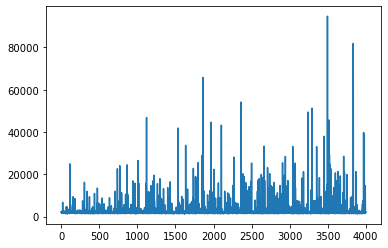

In [11]:
from pyro.infer import SVI, Trace_ELBO

def train(model, guide, *args, lr=0.001, n_steps=201, verbose=False):
    pyro.clear_param_store()
    initial_lr = lr
    gamma = 0.1  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    optim = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})
    svi = SVI(model, guide, optim, loss=Trace_ELBO(num_particles=1))

    losses = []
    for step in range(n_steps):
        loss = svi.step(*args)
        losses.append(loss)
        if step % 500 == 0 and verbose:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

    return losses

losses= train(
    model,posterior_module.guide, train_k, train_s11*1e6,
    lr=0.001,n_steps=4000, verbose=True
)
plt.plot(losses)



In [12]:
# print model params
for m in models:
    print(list(m.named_parameters()))
    
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

[('lambda_1', Parameter containing:
tensor(0.3317, requires_grad=True)), ('lambda_2', Parameter containing:
tensor(0.2150, requires_grad=True)), ('c', Parameter containing:
tensor(-2.5876, requires_grad=True))]
[('lambda_1', Parameter containing:
tensor(0.2993, requires_grad=True)), ('lambda_2', Parameter containing:
tensor(-0.0304, requires_grad=True)), ('c', Parameter containing:
tensor(-0.1302, requires_grad=True))]
model.guide.locs.c 0.052567087
model.guide.scales.c 0.112781964
model.guide.locs.lambda_1 0.0060901693
model.guide.scales.lambda_1 0.06986296
model.guide.locs.lambda_2 -0.021454189
model.guide.scales.lambda_2 0.15149836


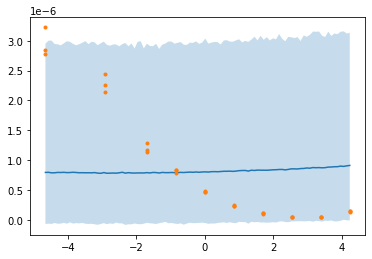

In [13]:
posterior_predictive = Predictive(model, num_samples=800, parallel=True,
                               guide=posterior_module.guide)
test_k = torch.linspace(train_k.min(),train_k.max(),100)

posterior_samples = posterior_predictive(test_k)

def get_stats(samples):
    mean = torch.mean(samples, dim=0)
    l = torch.quantile(samples, 0.05, dim=0)
    u = torch.quantile(samples, 0.95, dim=0)
    return mean, l, u

fig, ax = plt.subplots()
m, l, u = get_stats(posterior_samples["obs"].squeeze()/1e6)
ax.plot(test_k.squeeze().cpu(), m.cpu())
ax.fill_between(test_k.squeeze().cpu(), l.cpu(), u.cpu(), alpha=0.25)

ax.plot(train_k.squeeze().cpu(), train_s11.squeeze().cpu(), '.')

In [14]:
c = posterior_samples["c"]
l1 = posterior_samples["lambda_1"]
l2 = posterior_samples["lambda_2"]

norm_c = torch.tanh(c)
norm_emit = (l1**2 * l2**2 * (1 - norm_c**2)).sqrt()
emit = norm_emit * A ** 2
emit=emit* 63.0 / 0.511

In [15]:
qs = torch.quantile(emit, torch.tensor([0.05,0.5-0.34,0.5,0.5+0.34,0.95]))
print(qs)
print(emit.mean())
print(emit.std())

tensor([6.9775e-08, 3.0510e-07, 1.5779e-06, 5.0710e-06, 8.9218e-06])
tensor(2.6950e-06)
tensor(3.0757e-06)


(array([449., 170.,  77.,  52.,  19.,  16.,   7.,   2.,   5.,   3.]),
 array([3.3504136e-10, 1.9508736e-06, 3.9014121e-06, 5.8519504e-06,
        7.8024887e-06, 9.7530274e-06, 1.1703566e-05, 1.3654105e-05,
        1.5604643e-05, 1.7555181e-05, 1.9505720e-05], dtype=float32),
 <BarContainer object of 10 artists>)

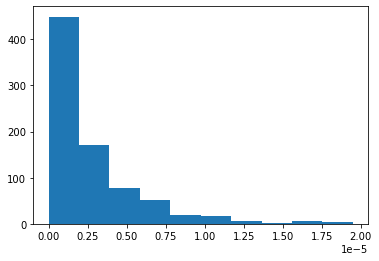

In [16]:
plt.hist(emit.numpy())